In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

import model_paths

from tensorboardX import SummaryWriter
%load_ext line_profiler

colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                   '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00'])

norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1, clip=False)

In [2]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [3]:
moons_data, moons_label = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

data = (torch.tensor(moons_data, dtype=torch.float) + 1.6) / 4
label = torch.tensor(moons_label, dtype=torch.float)
label = label.type(torch.LongTensor)

train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)

net = TwoMoonsNet()

clf = mixture.GaussianMixture(n_components=50, 
                              covariance_type='spherical',
                              max_iter=500)
clf.fit(data.numpy())

mu = clf.means_
std = np.sqrt(clf.covariances_)

mu = torch.tensor(clf.means_ ,dtype=torch.float)
logvar = torch.tensor(np.log(clf.covariances_) ,dtype=torch.float)

gmm = models.GMM(50, 2, mu=mu, logvar=logvar)

device=torch.device('cuda:0')

model = models.RobustModel(net, gmm, 0., dim=2, classes=2).to(device)
base_model = TwoMoonsNet().to(device)

In [4]:
model.mm.mu.data += .1*(torch.rand_like(model.mm.mu)-.5)
mu = model.mm.mu

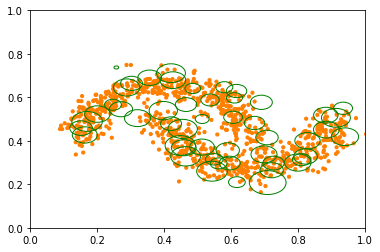

In [5]:
ax = plt.gca()
ax.cla()

y = model(data.to(device)).detach().cpu()
ax.scatter(data[:, 0], data[:, 1], s=10, color=colors[y.max(1)[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])

for i in range(mu.shape[0]):
    std = model.mm.logvar[i].exp().sqrt().item()
    ellipse = patches.Ellipse( (mu[i,0], mu[i,1]) , 3*std, 3*std, color='g', fill=False) 
    ax.add_artist(ellipse)

In [6]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

param_groups = [{'params':model.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(1000):
    tt.train_CEDA_gmm(model, device, train_loader, optimizer, epoch, lam=1., verbose=-1)
    

In [7]:
optimizer = optim.SGD(base_model.parameters(), lr=lr, weight_decay=decay)

for epoch in range(1000):
    tt.train_plain(base_model, device, train_loader, optimizer, epoch, lam=1., verbose=-1)

In [11]:
def cross_over(y, x, model):
    data = torch.tensor([[x, y]])
    out = model(data)
    return out[0,0]-out[0,1]

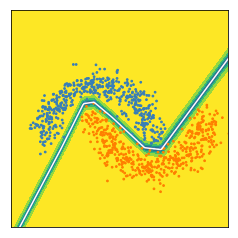

In [12]:
f = plt.figure()

x = np.arange(0., 1.01, 0.01)
y = np.arange(0., 1.01, 0.01)

points = []
for xx in x:
    for yy in y:
        points.append((xx, yy))

output = base_model.cpu()(torch.tensor(points)).detach()
output_data = base_model(data).detach().cpu()
pred = output.max(1)[0].exp()
z = pred.view(len(x), len(y)).detach().t().numpy()

ax = plt.gca()
ax.cla()

h = ax.contourf(x,y,z, norm=norm)

#h = ax.contour(x,y,z, norm=norm)

ax.scatter(data[:, 0], data[:, 1], s=3, color=colors[output_data.max(1)[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([])

dec_x = np.linspace(0,1,200)
dec_y = [scipy.optimize.brentq(cross_over, -0.1, 1.1, 
                               args = (xx, base_model)) for xx in dec_x]
plt.plot(dec_x, dec_y, color='white')

plt.gca().set_aspect('equal', adjustable='box')
    


In [13]:
f.savefig('results/two_moons1.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)

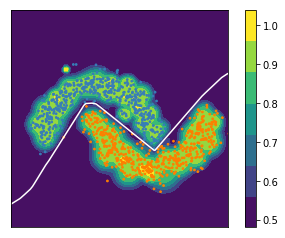

In [14]:
f = plt.figure()

output = model.cpu()(torch.tensor(points)).detach()
output_data = model(data).detach().cpu()
pred = output.max(1)[0].exp()
z = pred.view(len(x), len(y)).detach().t().numpy()

output_base = model.base_model.cpu()(torch.tensor(points)).detach()
pred = output_base.max(1)[0].exp()
z_base = pred.view(len(x), len(y)).detach().t().numpy()

ax = plt.gca()
ax.cla()

plt.contourf(x,y,z, vmin=.5, vmax=1., extend='neither')

norm2 = matplotlib.colors.Normalize(vmin=0.5, vmax=.6, clip=True)
cb = plt.colorbar(ticks=np.linspace(.5,1.,6))


# h = ax.contour(x,y,np.log(z_base-.5002)**3)


ax.scatter(data[:, 0], data[:, 1], s=3, color=colors[output_data.max(1)[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([])

dec_x = np.linspace(0,1,200)
dec_y = [scipy.optimize.brentq(cross_over, -0.1, 1.1, 
                               args = (xx, model.base_model)) for xx in dec_x]
plt.plot(dec_x, dec_y, color='white')

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [15]:
f.savefig('results/two_moons2.eps', format='eps', bbox_inches = 'tight',
    pad_inches = 0)